In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV

np.random.seed(101)

sns.set()
plt.rcParams['figure.figsize'] = (9.0, 7.0)

## Gaussian Graphical Model (GGM)
多変量正規分布&thinsp; $N(\boldsymbol{\mu}, \Sigma)$&thinsp; に従う確率変数ベクトル&thinsp; $\boldsymbol{X} = (X_{1}, ..., X_{p})^{T}$&thinsp; において変数間の関係性を推定する手法
<br>
***
###  (復習)多変量正規分布
p次元正規分布の確率密度関数は以下
<br>
<br>
$$f(\mathbf{x};\boldsymbol{\mu}, \Sigma) = \frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}}exp\Bigl\{ -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{T}\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})\Bigr\}$$
<br>
ただし&thinsp; $\boldsymbol{\mu} \in \mathbb{R}^p,  \Sigma \in \mathbb{R}^{p \times p}$
<br>
<br>
***

###  GGMにおけるスパース推定
共分散行列&thinsp; $\Sigma$&thinsp; をスパースに推定することが目標なので、データを予め中心化して $\boldsymbol{\mu}=\boldsymbol{0}$ とすると $\boldsymbol{X} \sim N(\boldsymbol{0}, \Omega^{-1})$ ($\Omega = \Sigma^{-1}$) 
<br>
<br>
対数尤度関数を求めると
<br>
<br>
$$L(\Sigma) = - log|\Omega| + tr(\Omega \boldsymbol{S}) \tag{1}$$
<br>
ただし $\boldsymbol{S}$ は標本分散共分散行列
<br>
<br>
$$\boldsymbol{S} = \boldsymbol{X}\boldsymbol{X}^T \tag{2}$$
<br>
(1)にL1正則化を加えたもの
<br>
<br>
$$L(\Omega) = -log|\Omega| + tr(\Omega \boldsymbol{S}) + \lambda\sum^{p}_{j=1}\sum^{p}_{k=1}|w_{jk}| \tag{3}$$
<br>
を考える
#### Graphical lasso (Friedman et al., 2008)
ブロック座標降下法というアルゴリズムを用いて式(3)を最小にする $\Omega$ を高速に求められるようにしたアルゴリズム
<br>
<br>
(3)を $\Omega$ に関して微分すると,
<br>
<br>
$$\Omega^{-1} - S - \lambda \Gamma = O \tag{4}$$
<br>
<br>
ただし $\Gamma$ は $ij$ 成分が $\omega_{jk} = 0$ のとき $[-1, 1]$, その他の場合 $sign(\omega_{jk})$ で与えられるような行列.  また、パラメータを以下のように分割
<br>
<br>
$$\Sigma = \begin{bmatrix}
\tilde \Sigma & \boldsymbol{\sigma_1} \\
\boldsymbol{\sigma_1}^T & \sigma
\end{bmatrix},      
\Omega = \begin{bmatrix}
\tilde \Omega & \boldsymbol{\omega_1} \\
\boldsymbol{\omega_1}^T & \omega
\end{bmatrix},
S = \begin{bmatrix}
\tilde S & \boldsymbol{s_1} \\
\boldsymbol{s_1}^T & s
\end{bmatrix} $$
<br>
<br>
恒等式 $\Sigma\Omega = I_p$ が成り立つ. すなわち
<br>
<br>
$$\begin{bmatrix}
\tilde \Sigma & \boldsymbol{\sigma_1} \\
\boldsymbol{\sigma_1}^T & \sigma
\end{bmatrix}
\begin{bmatrix}
\tilde \Omega & \boldsymbol{\omega_1} \\
\boldsymbol{\omega_1}^T & \omega
\end{bmatrix} = 
\begin{bmatrix}
I_p & \boldsymbol{0} \\
\boldsymbol{0}^T & 1
\end{bmatrix} \tag{5}$$
<br>
(4)の右上のブロックに注目すると、(5)より $\tilde\Sigma\boldsymbol{\omega_1} + \omega\boldsymbol{\sigma_1} = \boldsymbol{0}$ だから,
<br>
<br>
$$\tilde\Sigma\boldsymbol{\beta_0} - \boldsymbol{s_1} + \lambda\boldsymbol{\gamma} = \boldsymbol{0}$$
<br>
ただし $\boldsymbol{\beta_0} = \tilde \Sigma^{-1} \boldsymbol{\sigma_1}$. また、 $\Omega$ が正定値より $\omega > 0$ だから $sign(\boldsymbol{\omega_1}) = -sign(\boldsymbol{\beta_0})$. よって $\gamma_j \in sign(\beta_{0j})$ とおける.
<br>
<br>
これを満たす $\boldsymbol{\beta_0}$ は以下
<br>
<br>
$$\boldsymbol{\beta_0} = \mathop{\rm arg~min}\limits_{\beta}\Bigl\{\frac{1}{2}||\boldsymbol{y}-\tilde\Sigma^{1/2}\boldsymbol{\beta}||^2_2 + \lambda||\beta||_1  \Bigr\}, ~~~\boldsymbol{y} = \tilde\Sigma^{1/2}\boldsymbol{s_1}$$
<br>
Lasso回帰と同じ形になった！あとは座標降下法を使ってこれを解くことを繰り返すだけ. (詳細はp.111)

In [5]:
# Generate the data
n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=prng)

cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [7]:
# Estimate the covariance
emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

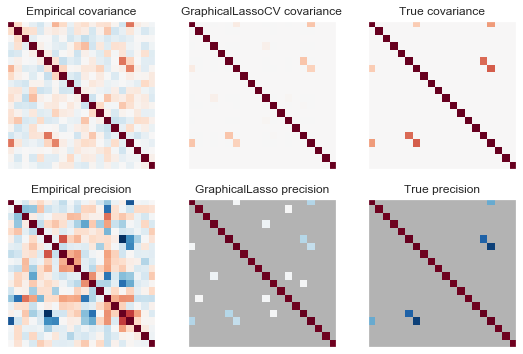

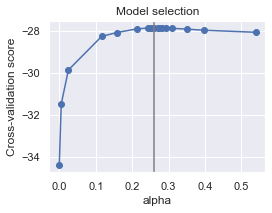

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_cov),
        ('GraphicalLassoCV', cov_), ('True', cov)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)


# plot the precisions
precs = [('Empirical', linalg.inv(emp_cov)), 
         ('GraphicalLasso', prec_), ('True', prec)]
vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')

# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_alphas_, np.mean(model.grid_scores_, axis=1), 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()